Start of EDA

In [1]:
import sys
from pathlib import Path
import pandas as pd
import os

project_root = Path("..").resolve()
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from data_prep import *
from imports import *

file_path = project_root / "data/raw/desafio_indicium_imdb.csv"
df = load_data(file_path=file_path)

print("\nInitial Data:")
# Initial Data Check

print(df.shape)
print(df.info())

missing_summary = missing_values_summary(df)
print("\nMissing values summary:")
print(missing_summary)

FileNotFoundError: File not found at C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\data\raw\desafio_indicium_imdb.csv

In [ ]:
df.head(5)

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [ ]:
# Check for duplicate movies based on title, release year, and director

duplicates = check_duplicates(df, ["Series_Title", "Released_Year", "Director"])

if duplicates is not None:
    display(duplicates)

Data Cleaning and Standardization

In [ ]:
# Rename specific columns to standardized names
df = clean_column_names(df)

In [ ]:
# Convert 'Runtime' from string to integer minutes and drop original column
if 'Runtime' in df.columns:
    df['Runtime_Min'] = (
        df['Runtime']
        .astype(str)
        .str.replace('min', '', regex=False)
        .str.strip()
        .replace('', None)
        .astype('Int64')  # nullable integer type
    )
    df = df.drop(columns=['Runtime'])

In [ ]:
# Clean and standardize text columns in the DataFramefrom src.data_prep import clean_text_columns
df_clean = clean_text_columns(df)

In [ ]:
# Apply normalization to the 'Certificate' column to standardize rating categories
df_clean['Certificate'] = df_clean['Certificate'].apply(normalize_certificate)

In [ ]:
# Process 'Genre' column to create multi-hot encodad features
if 'Genre' in df_clean.columns:
    df_clean['Genre_List'] = df_clean['Genre'].apply(split_genres)

    mlb = MultiLabelBinarizer()
    multi_hot = pd.DataFrame(
        mlb.fit_transform(df_clean['Genre_List']),
        columns=mlb.classes_,
        index=df_clean.index
    )

    df_clean = pd.concat([df_clean, multi_hot], axis=1)

    df_clean.drop(columns=['Genre_List', 'Genre'], inplace=True)

In [ ]:
# Convert 'Gross' column to numeric USD values and remove the original column
if 'Gross' in df_clean.columns:
    df_clean['Gross_USD'] = (
        df_clean['Gross']
        .astype(str)
        .str.replace(r'[^0-9]', '', regex=True)
        .replace('', None)
        .astype(float)
    )

    df_clean.drop(columns=['Gross'], inplace=True)

In [ ]:
# Convert selected columns to numeric types, handling non-numeric values gracefully
if 'Released_Year' in df_clean.columns:
    df_clean['Released_Year'] = (
        pd.to_numeric(df_clean['Released_Year'], errors='coerce')
        .astype('Int64')
    )

if 'Meta_score' in df_clean.columns:
    df_clean['Meta_score'] = pd.to_numeric(df_clean['Meta_score'], errors='coerce')

if 'No_of_Votes' in df_clean.columns:
    df_clean['No_of_Votes'] = pd.to_numeric(df_clean['No_of_Votes'], errors='coerce')

if 'IMDB_Rating' in df_clean.columns:
    df_clean['IMDB_Rating'] = pd.to_numeric(df_clean['IMDB_Rating'], errors='coerce')

In [ ]:
# Display the first 10 rows of the cleaned DataFrame
print('After cleaning:')
display(df_clean.head(10))

After cleaning:


,Index,Movie_title,Released_Year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,...,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Gross_USD
0,1,The Godfather,1972,PG,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,...,0,0,0,0,0,0,0,0,0,134966411.0
1,2,The Dark Knight,2008,PG,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,...,0,0,0,0,0,0,0,0,0,534858444.0
2,3,The Godfather: Part II,1974,PG,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,...,0,0,0,0,0,0,0,0,0,57300000.0
3,4,12 Angry Men,1957,G,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,...,0,0,0,0,0,0,0,0,0,4360000.0
4,5,The Lord of the Rings: The Return of the King,2003,G,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,...,0,0,0,0,0,0,0,0,0,377845905.0
5,6,Pulp Fiction,1994,PG,8.9,"The lives of two mob hitmen, a boxer, a gangst...",94.0,Quentin Tarantino,John Travolta,Uma Thurman,...,0,0,0,0,0,0,0,0,0,107928762.0
6,7,Schindler's List,1993,PG,8.9,"In German-occupied Poland during World War II,...",94.0,Steven Spielberg,Liam Neeson,Ralph Fiennes,...,0,0,0,0,0,0,0,0,0,96898818.0
7,8,Inception,2010,PG,8.8,A thief who steals corporate secrets through t...,74.0,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,...,0,0,0,0,1,0,0,0,0,292576195.0
8,9,Fight Club,1999,PG,8.8,An insomniac office worker and a devil-may-car...,66.0,David Fincher,Brad Pitt,Edward Norton,...,0,0,0,0,0,0,0,0,0,37030102.0
9,10,The Lord of the Rings: The Fellowship of the Ring,2001,G,8.8,A meek Hobbit from the Shire and eight compani...,92.0,Peter Jackson,Elijah Wood,Ian McKellen,...,0,0,0,0,0,0,0,0,0,315544750.0


In [ ]:
print(df_clean.columns.tolist())

['Index', 'Movie_title', 'Released_Year', 'Certificate', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Runtime_Min', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'Gross_USD']


In [ ]:
# Display percentage of missing values per column for df_clean
print(missing_values_summary(df_clean))

Gross_USD        16.916917
Meta_score       15.715716
Released_Year     0.100100
Musical           0.000000
Family            0.000000
Fantasy           0.000000
Film-Noir         0.000000
History           0.000000
Horror            0.000000
Music             0.000000
Romance           0.000000
Mystery           0.000000
Crime             0.000000
Sci-Fi            0.000000
Sport             0.000000
Thriller          0.000000
War               0.000000
Western           0.000000
Drama             0.000000
Index             0.000000
Movie_title       0.000000
Biography         0.000000
Animation         0.000000
Adventure         0.000000
Action            0.000000
Runtime_Min       0.000000
No_of_Votes       0.000000
Star4             0.000000
Star3             0.000000
Star2             0.000000
Star1             0.000000
Director          0.000000
Overview          0.000000
IMDB_Rating       0.000000
Certificate       0.000000
Comedy            0.000000
dtype: float64


In [ ]:
# Fill missing 'Released_Year' for "Apollo 13" and convert the column to integer type
df_clean[df_clean['Released_Year'].isna()]

df_clean.loc[df_clean['Movie_title'] == 'Apollo 13', 'Released_Year'] = 1995
df_clean['Released_Year'] = df_clean['Released_Year'].astype('Int64')

In [ ]:
# Define project root (outside notebooks)
project_root = Path("..").resolve()
save_path = project_root / "data" / "processed" / "imdb_clean.csv"

df_clean.to_csv(save_path, index=False)

print(f"CSV saved at: {save_path}")

CSV saved at: C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\data\processed\imdb_clean.csv


# Exploratory Data Analysis (EDA)

In [ ]:
from src.plots import *

In [ ]:
# Identifying numerical and categorical columns
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df_clean.columns if c not in num_cols]

print('Numerical columns:', num_cols)
print('Categorial columns:', cat_cols)
display(df_clean[num_cols].describe().T)

Numerical columns: ['Index', 'Released_Year', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Runtime_Min', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'Gross_USD']
Categorial columns: ['Movie_title', 'Certificate', 'Overview', 'Director', 'Star1', 'Star2', 'Star3', 'Star4']


,count,mean,std,min,25%,50%,75%,max
Index,999.0,500.0,288.530761,1.0,250.5,500.0,749.5,999.0
Released_Year,999.0,1991.218218,23.297166,1920.0,1976.0,1999.0,2009.0,2020.0
IMDB_Rating,999.0,7.947948,0.27229,7.6,7.7,7.9,8.1,9.2
Meta_score,842.0,77.969121,12.383257,28.0,70.0,79.0,87.0,100.0
No_of_Votes,999.0,271621.422422,320912.621055,25088.0,55471.5,138356.0,373167.5,2303232.0
Runtime_Min,999.0,122.871872,28.101227,45.0,103.0,119.0,137.0,321.0
Action,999.0,0.189189,0.391855,0.0,0.0,0.0,0.0,1.0
Adventure,999.0,0.196196,0.397318,0.0,0.0,0.0,0.0,1.0
Animation,999.0,0.082082,0.274627,0.0,0.0,0.0,0.0,1.0
Biography,999.0,0.109109,0.311932,0.0,0.0,0.0,0.0,1.0


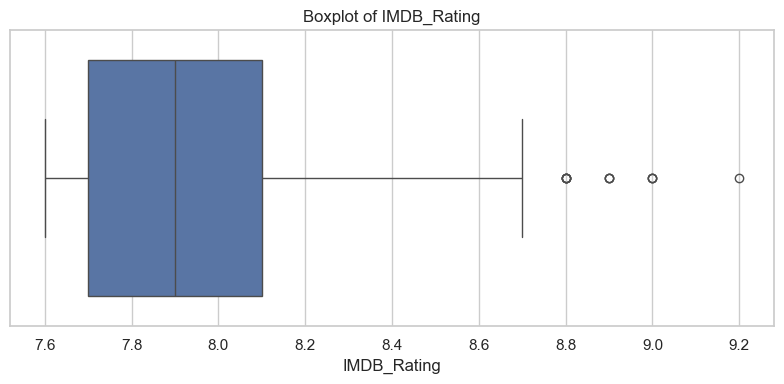

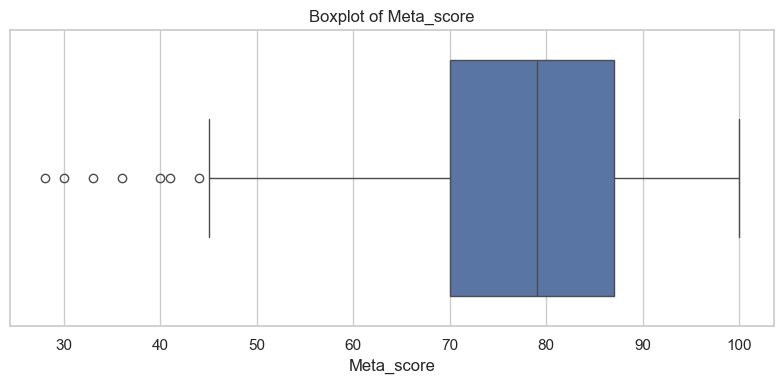

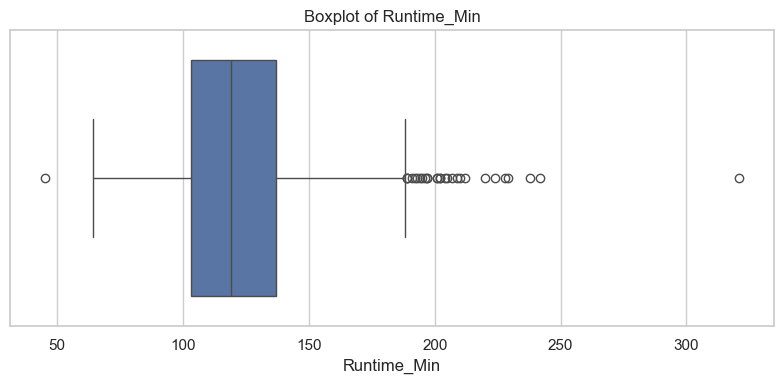

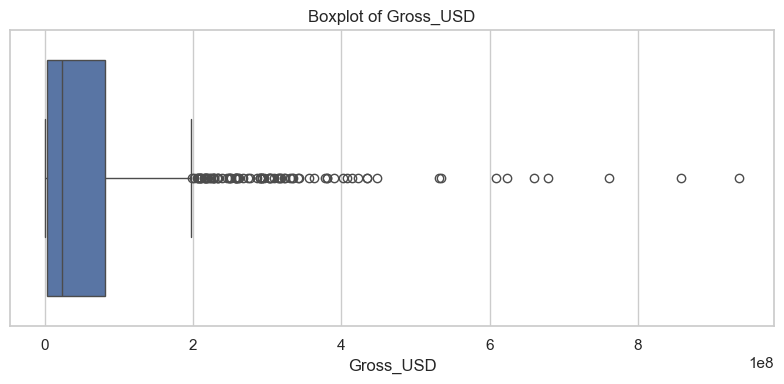

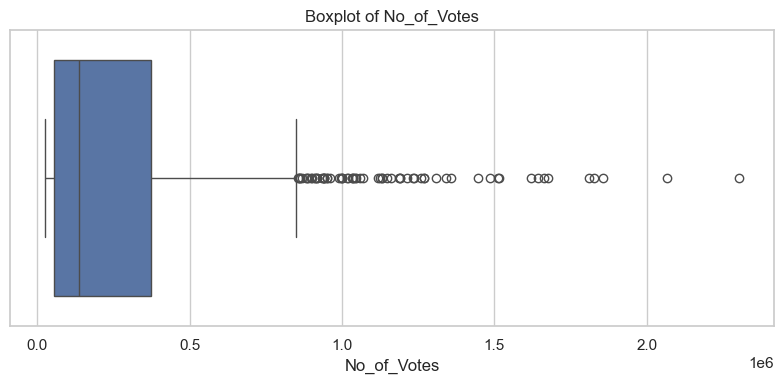

In [ ]:
# Check for outliers using boxplots for numeric columns
#from src.plots import boxplots_numeric

numeric_cols = ['IMDB_Rating', 'Meta_score', 'Runtime_Min', 'Gross_USD', 'No_of_Votes']

boxplots_numeric(df_clean, numeric_cols)

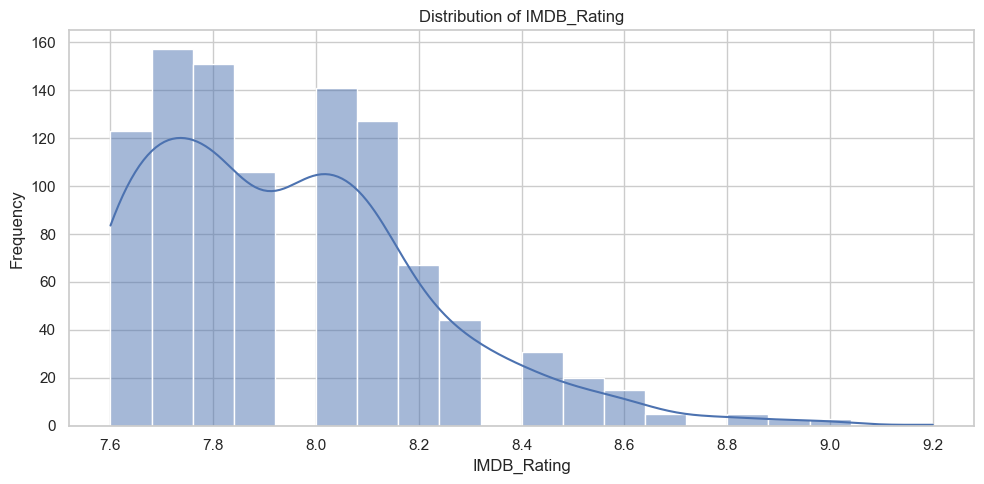

In [ ]:
# Histogram
plot_hist(df_clean, 'IMDB_Rating', bins=20)

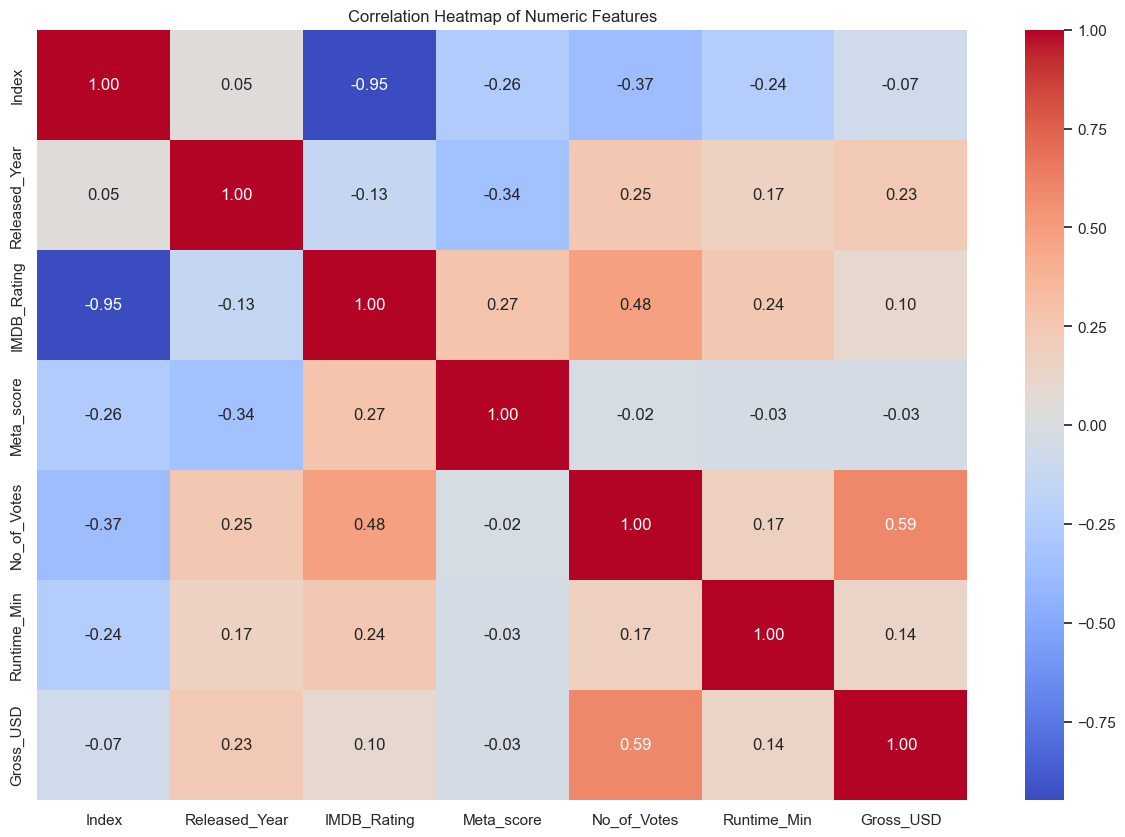

In [ ]:
# Correlation Heatmap
plot_corr_heatmap(df_clean)

In [ ]:
print('\nTop Certificates:')
if 'Certificate' in df_clean.columns:
    display(top_n(df_clean['Certificate']))
else:
    print('Certificate missing.')


Top Certificates:


Certificate
PG         459
G          246
R          147
UNRATED    103
PG-13       44
Name: count, dtype: int64

Most of the top-rated IMDb movies in this dataset are targeted at general or family audiences. The majority of films have a "PG" or "G" rating, suggesting that family-friendly and broadly accessible movies are more likely to achieve high IMDb ratings. Conversely, movies with more restrictive ratings such as "R" or "PG-13" are less frequent, possibly indicating that niche or adult-oriented films are underrepresented in the top 1000 IMDb list.

C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cert_counts.index, y=cert_counts.values, palette='pastel')


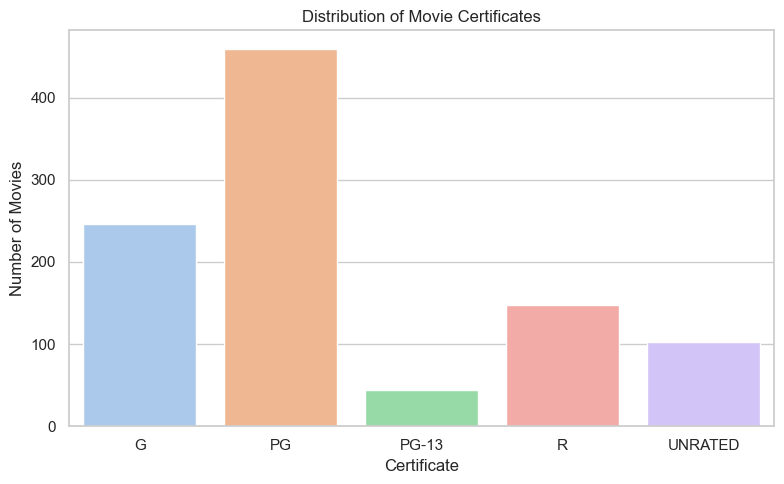

In [ ]:
#from src.plots import barplot_certificate_distribution

barplot_certificate_distribution(df_clean)


In [ ]:
genre_lists = df['Genre'].fillna('').apply(lambda x: [g.strip() for g in str(x).split(',')])
top_genres = genre_lists.explode().value_counts().head(20)
display(top_genres)

Genre
Drama        723
Comedy       233
Crime        209
Adventure    196
Action       189
Thriller     137
Romance      125
Biography    109
Mystery       99
Animation     82
Sci-Fi        67
Fantasy       66
Family        56
History       56
War           51
Music         35
Horror        32
Western       20
Film-Noir     19
Sport         19
Name: count, dtype: int64

C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='pastel')


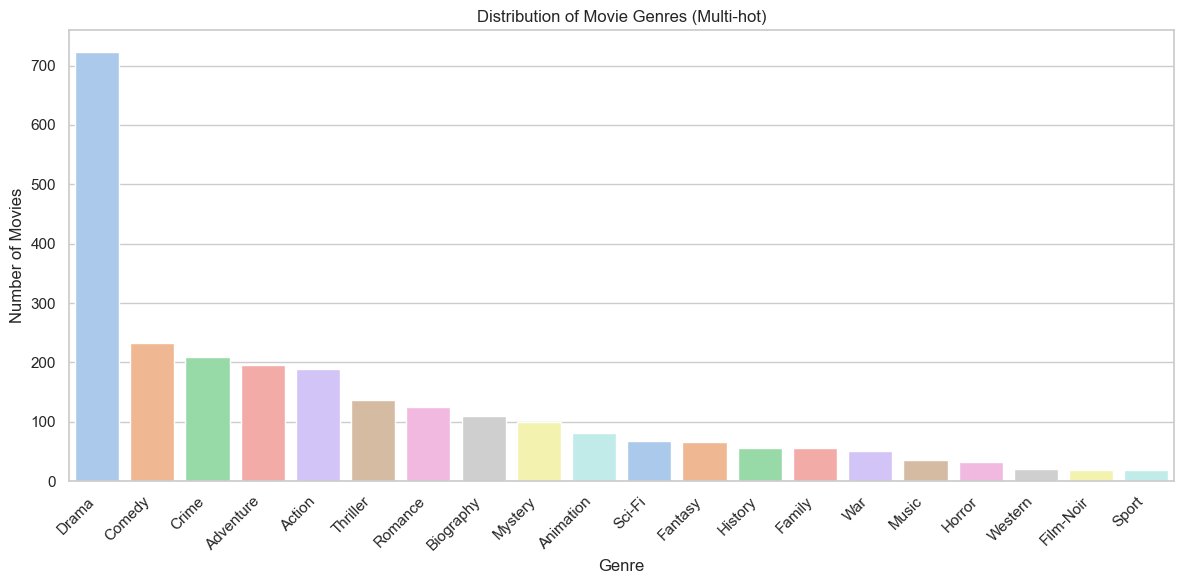

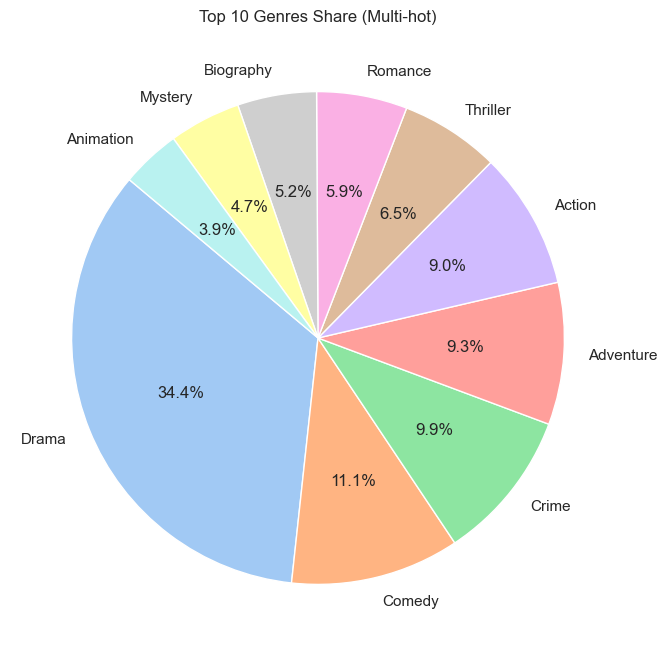

C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='Genre', y='Gross_USD', palette='pastel')


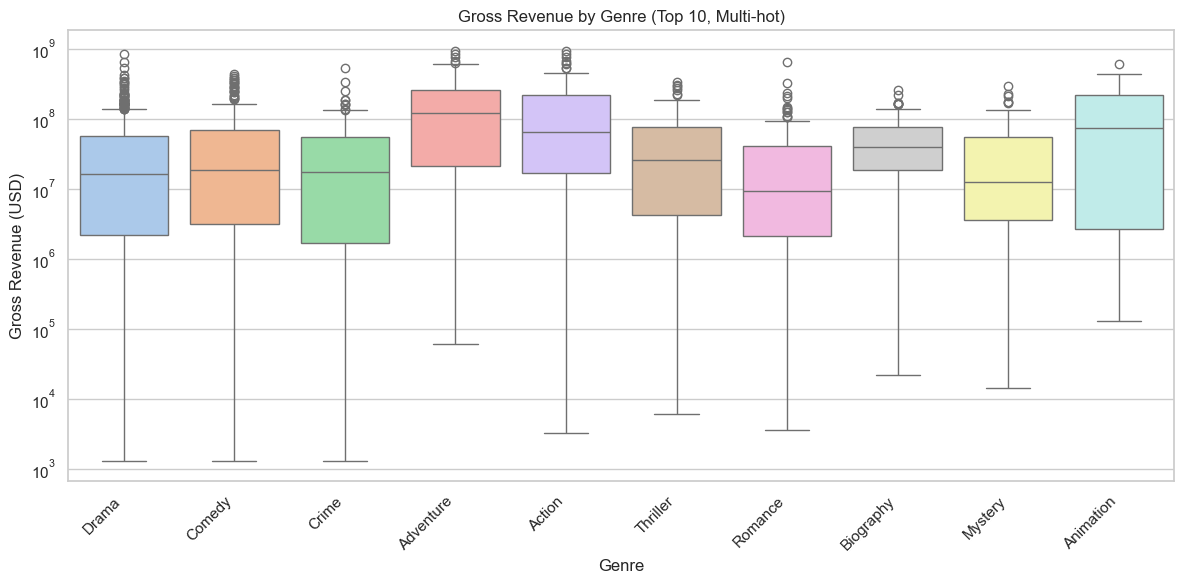

In [ ]:
# Run analysis on cleaned DataFrame
genre_analysis(df_clean)

In [ ]:
print('\nYears (min, max):')
if 'Released_Year' in df_clean.columns:
    print(int(df_clean['Released_Year'].min()), '->', int(df_clean['Released_Year'].max()))


Years (min, max):
1920 -> 2020


Total Gross Revenue by Top Genres:
Adventure    2.817432e+10
Drama        2.746928e+10
Action       2.203333e+10
Comedy       1.224793e+10
Sci-Fi       9.029610e+09
Animation    8.573824e+09
Crime        6.956304e+09
Thriller     6.454429e+09
Fantasy      6.082543e+09
Biography    5.304578e+09
dtype: float64


C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:192: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_gross.index, y=genre_gross.values, palette='pastel')


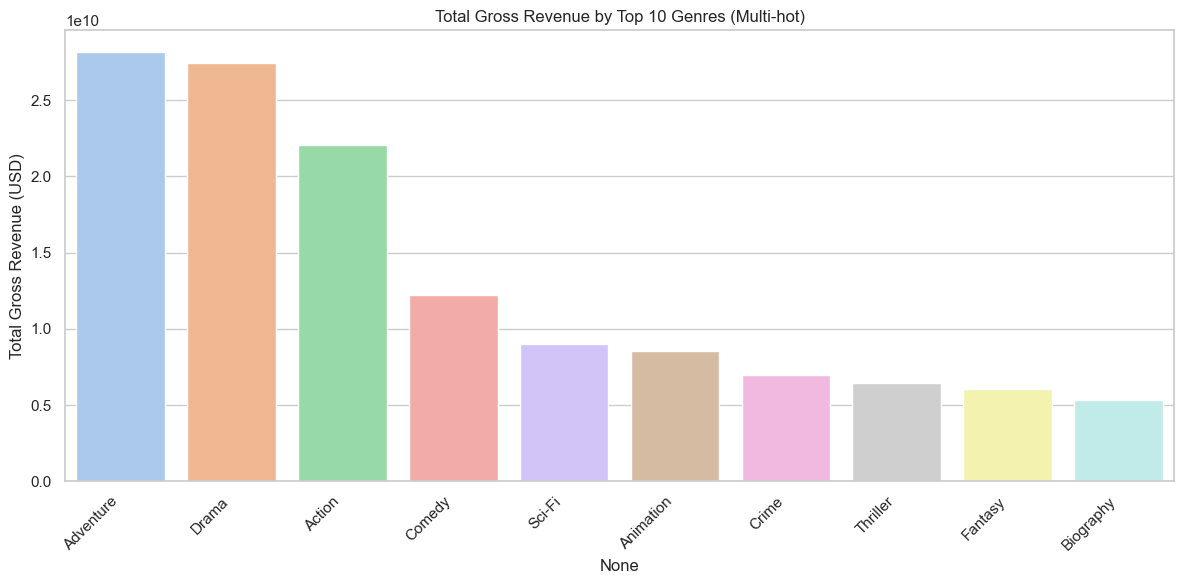

C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='Genre', y='Gross_USD', palette='pastel')


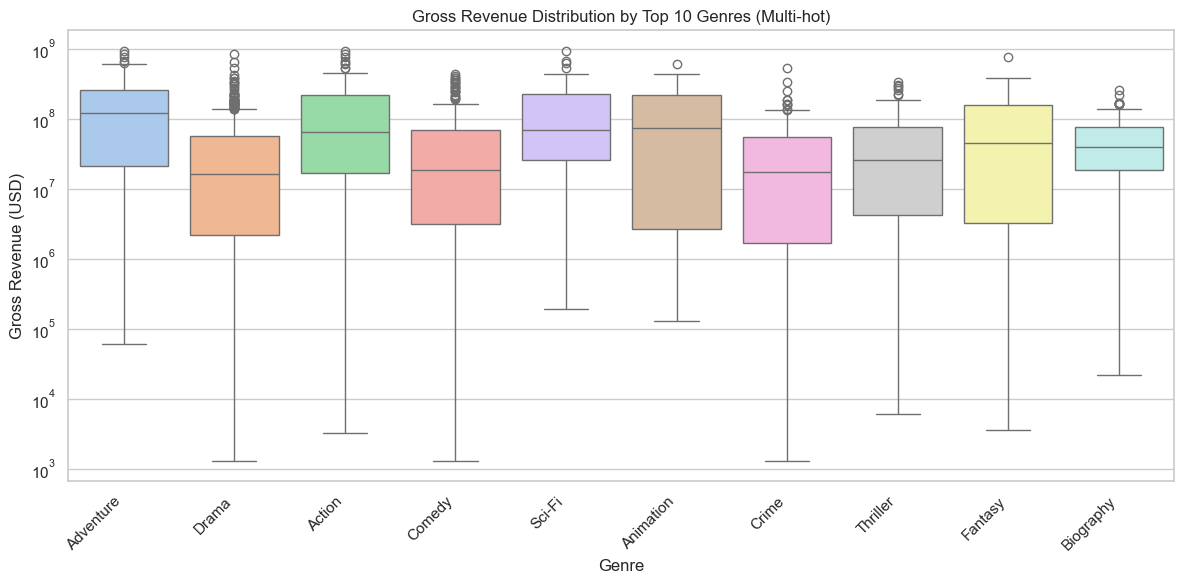

In [ ]:
import sys

if str(src_path) not in sys.path:
	sys.path.append(str(src_path))

from src.plots import genre_gross_analysis

# Se o seu DataFrame multi-hot é df_clean
genre_gross_analysis(df_clean, top_n=10)

Correlation Gross_USD vs IMDB_Rating: 0.13
Correlation Gross_USD vs Meta_score: -0.03


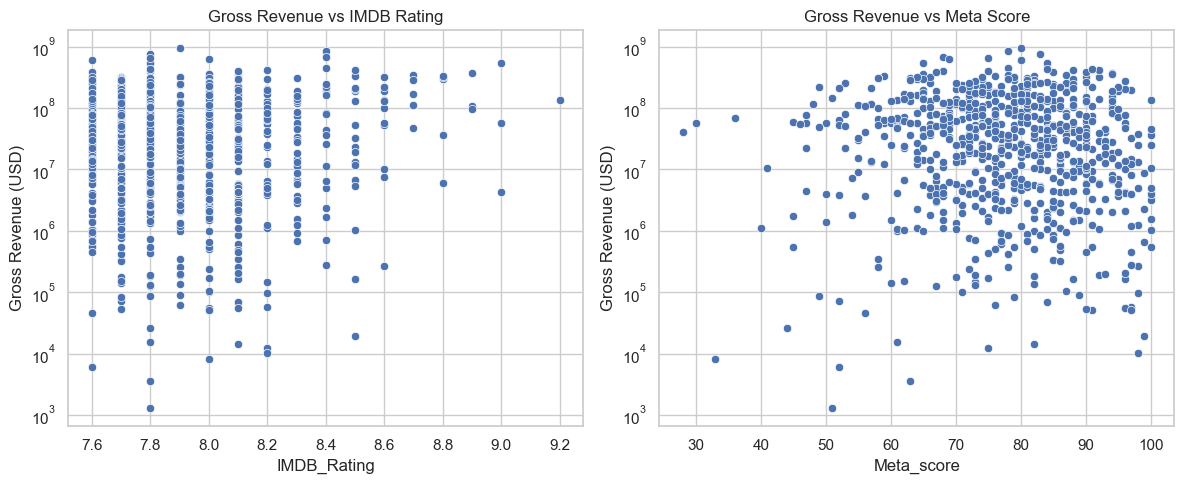

C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f'{col}_bin'] = pd.qcut(df_clean[col], bins, duplicates='drop')
C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_gross = df_clean.groupby(f'{col}_bin')['Gross_USD'].mean()
C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:274: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remov

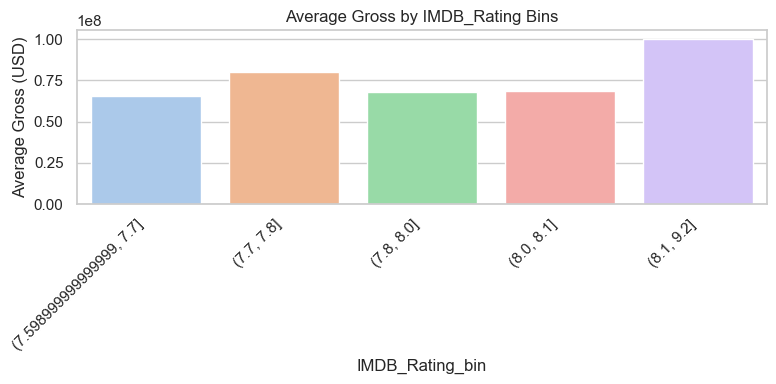

C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f'{col}_bin'] = pd.qcut(df_clean[col], bins, duplicates='drop')
C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_gross = df_clean.groupby(f'{col}_bin')['Gross_USD'].mean()
C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:274: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remov

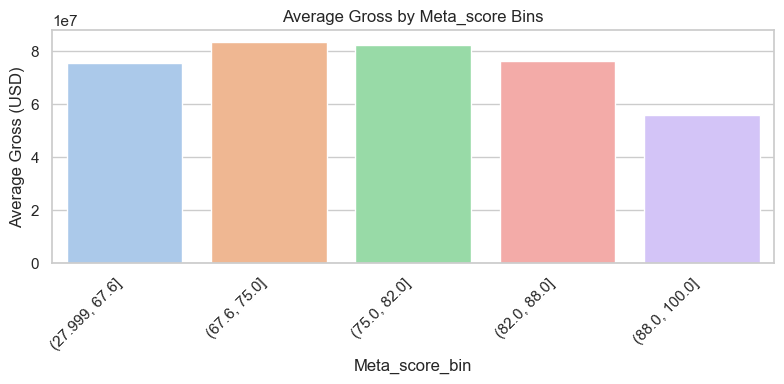

In [ ]:
# Call the function
rating_vs_gross(df_clean, bins=5)

             No_of_Votes  Meta_score  IMDB_Rating  Gross_USD
No_of_Votes     1.000000   -0.020091     0.479308   0.589527
Meta_score     -0.020091    1.000000     0.271374  -0.030480
IMDB_Rating     0.479308    0.271374     1.000000   0.099393
Gross_USD       0.589527   -0.030480     0.099393   1.000000


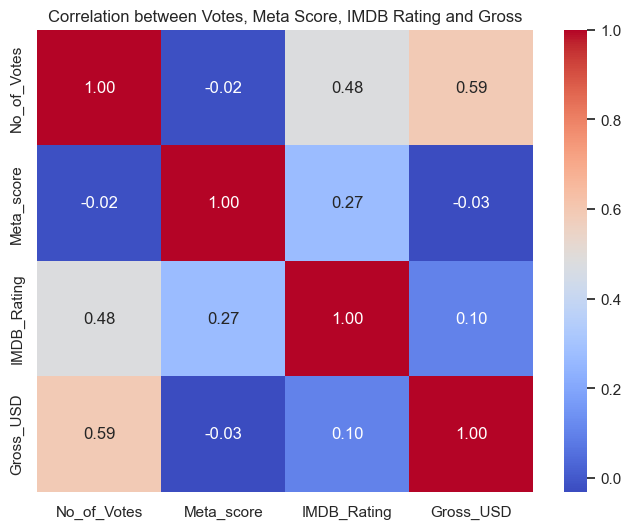

In [ ]:

num_cols = ["No_of_Votes", "Meta_score", "IMDB_Rating", "Gross_USD"]

# Filtrar apenas colunas que existam no DataFrame
num_cols = [col for col in num_cols if col in df_clean.columns]

# Calcular a matriz de correlação
corr_matrix = df_clean[num_cols].corr(method="pearson")

print(corr_matrix)

# Plotar heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation between Votes, Meta Score, IMDB Rating and Gross")
plt.show()


  year_quartile    No_of_Votes     Gross_USD
0   Q1 - Oldest  130239.320158  2.687912e+07
1            Q2  304260.291188  6.251157e+07
2            Q3  346421.687764  6.965808e+07
3   Q4 - Newest  310021.681452  1.037204e+08


C:\Users\maria\AppData\Local\Temp\ipykernel_37044\718932746.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_stats = df_clean.groupby("year_quartile")[["No_of_Votes", "Gross_USD"]].mean().reset_index()


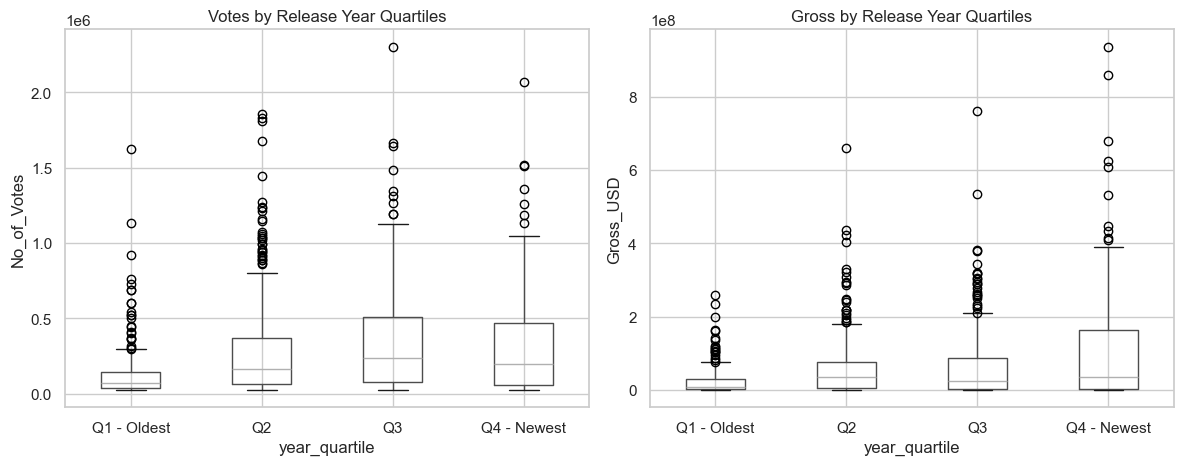

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Criar a coluna de quartis baseada no ano de lançamento
df_clean["year_quartile"] = pd.qcut(df_clean["Released_Year"], 4, labels=["Q1 - Oldest", "Q2", "Q3", "Q4 - Newest"])

# Estatísticas descritivas por quartil
agg_stats = df_clean.groupby("year_quartile")[["No_of_Votes", "Gross_USD"]].mean().reset_index()
print(agg_stats)

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Boxplot Votes
df_clean.boxplot(column="No_of_Votes", by="year_quartile", ax=axes[0])
axes[0].set_title("Votes by Release Year Quartiles")
axes[0].set_ylabel("No_of_Votes")

# Boxplot Gross
df_clean.boxplot(column="Gross_USD", by="year_quartile", ax=axes[1])
axes[1].set_title("Gross by Release Year Quartiles")
axes[1].set_ylabel("Gross_USD")

plt.suptitle("")  # remove título automático do pandas
plt.tight_layout()
plt.show()


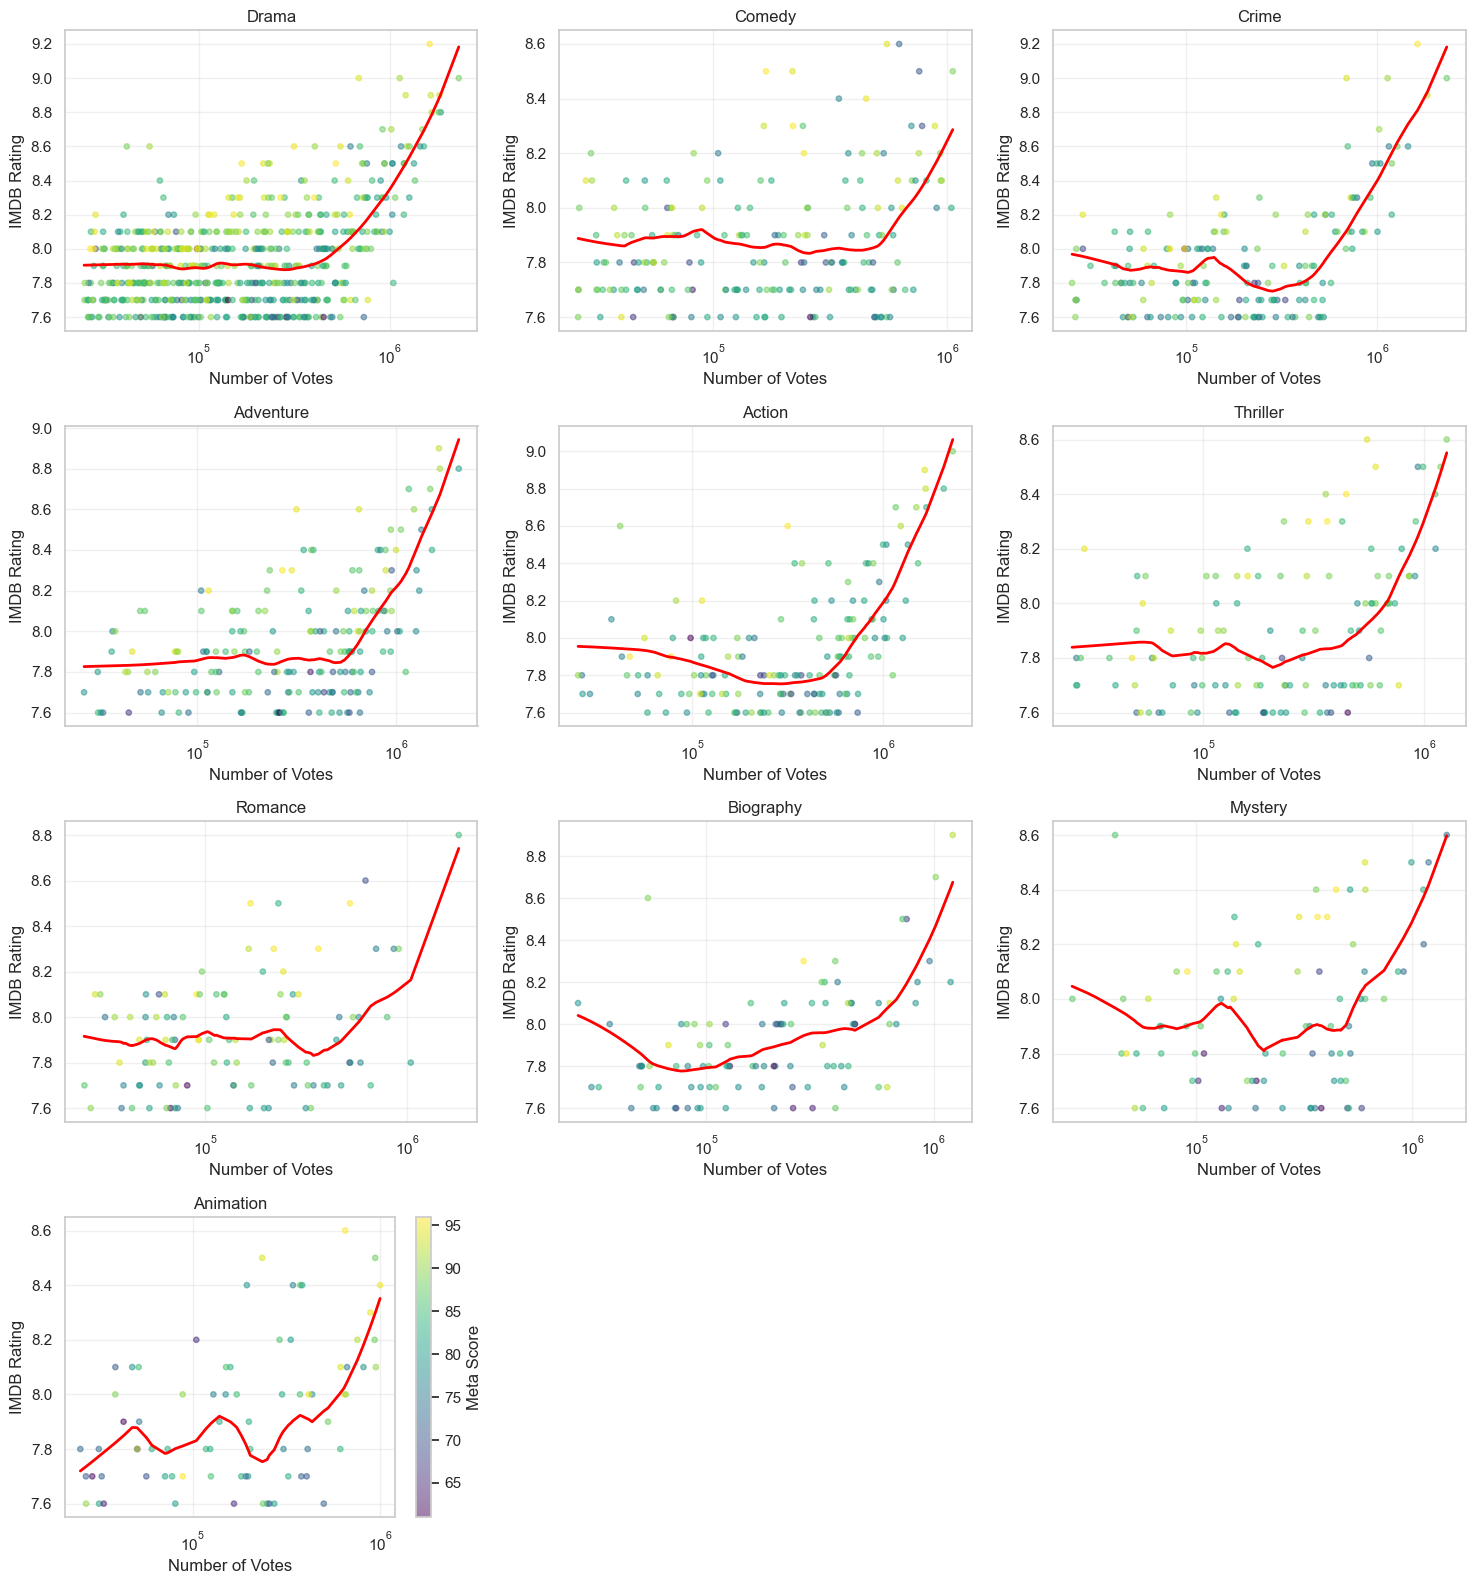

In [ ]:
genre_cols = [c for c in df_clean.columns 
              if set(df_clean[c].dropna().unique()).issubset({0,1}) and c != 'SomeNonGenreCol']  

genre_counts = {g: df_clean[g].sum() for g in genre_cols}

top_genres = sorted(genre_counts, key=genre_counts.get, reverse=True)[:10]

cols = 3
rows = int(np.ceil(len(top_genres) / cols))
plt.figure(figsize=(cols*5, rows*4))

for i, g in enumerate(top_genres):
    mask = df_clean[g] == 1
    x = df_clean.loc[mask, 'No_of_Votes'].dropna()
    y = df_clean.loc[mask, 'IMDB_Rating'].dropna()

    common_idx = x.index.intersection(y.index)
    x = x.loc[common_idx]
    y = y.loc[common_idx]

    ax = plt.subplot(rows, cols, i+1)


    scatter = ax.scatter(x, y, s=15, alpha=0.5, 
                         c=df_clean.loc[common_idx, 'Meta_score'], cmap='viridis')

    if len(x) > 0 and len(y) > 0:
        smoothed = lowess(y, x, frac=0.3)
        ax.plot(smoothed[:,0], smoothed[:,1], color='red', linewidth=2, label='LOWESS')

    ax.set_xscale('log')
    ax.set_title(g)
    ax.set_xlabel('Number of Votes')
    ax.set_ylabel('IMDB Rating')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.colorbar(scatter, label='Meta Score')
plt.show()


Top actors by total gross revenue:
                            sum          mean  count
Star1                                               
Tom Hanks          2.493097e+09  2.077581e+08     12
Joe Russo          2.205039e+09  5.512599e+08      4
Leonardo DiCaprio  1.877322e+09  2.085913e+08      9
Daniel Radcliffe   1.835901e+09  3.059835e+08      6
Christian Bale     1.351591e+09  1.689489e+08      8
Robert Downey Jr.  1.150720e+09  3.835734e+08      3
Elijah Wood        1.035942e+09  3.453140e+08      3
Daisy Ridley       9.366622e+08  9.366622e+08      1
Mark Hamill        9.223406e+08  3.074469e+08      3
Craig T. Nelson    8.700228e+08  4.350114e+08      2


C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:317: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Star1', y='sum', data=top_stars, palette='pastel')


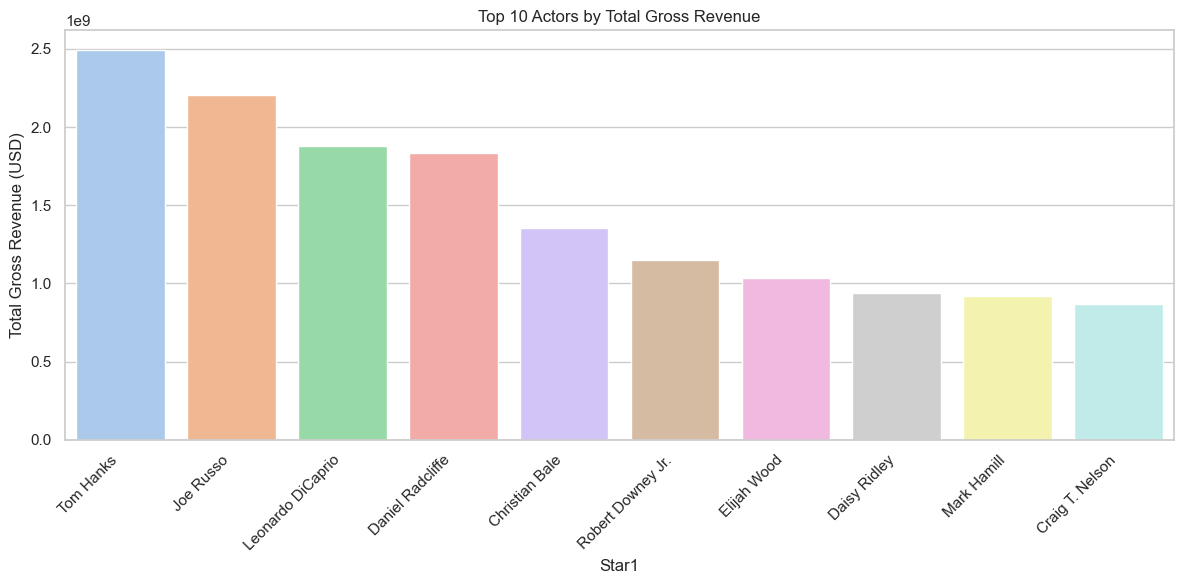

In [ ]:
# Call the function
star_gross_analysis(df_clean, top_n=10)

C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:357: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_appearances.index, y=top_appearances.values, ax=axs[i,0], palette='pastel')
C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:364: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gross_by_star.index, y=gross_by_star.values, ax=axs[i,1], palette='pastel')
C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:357: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=t

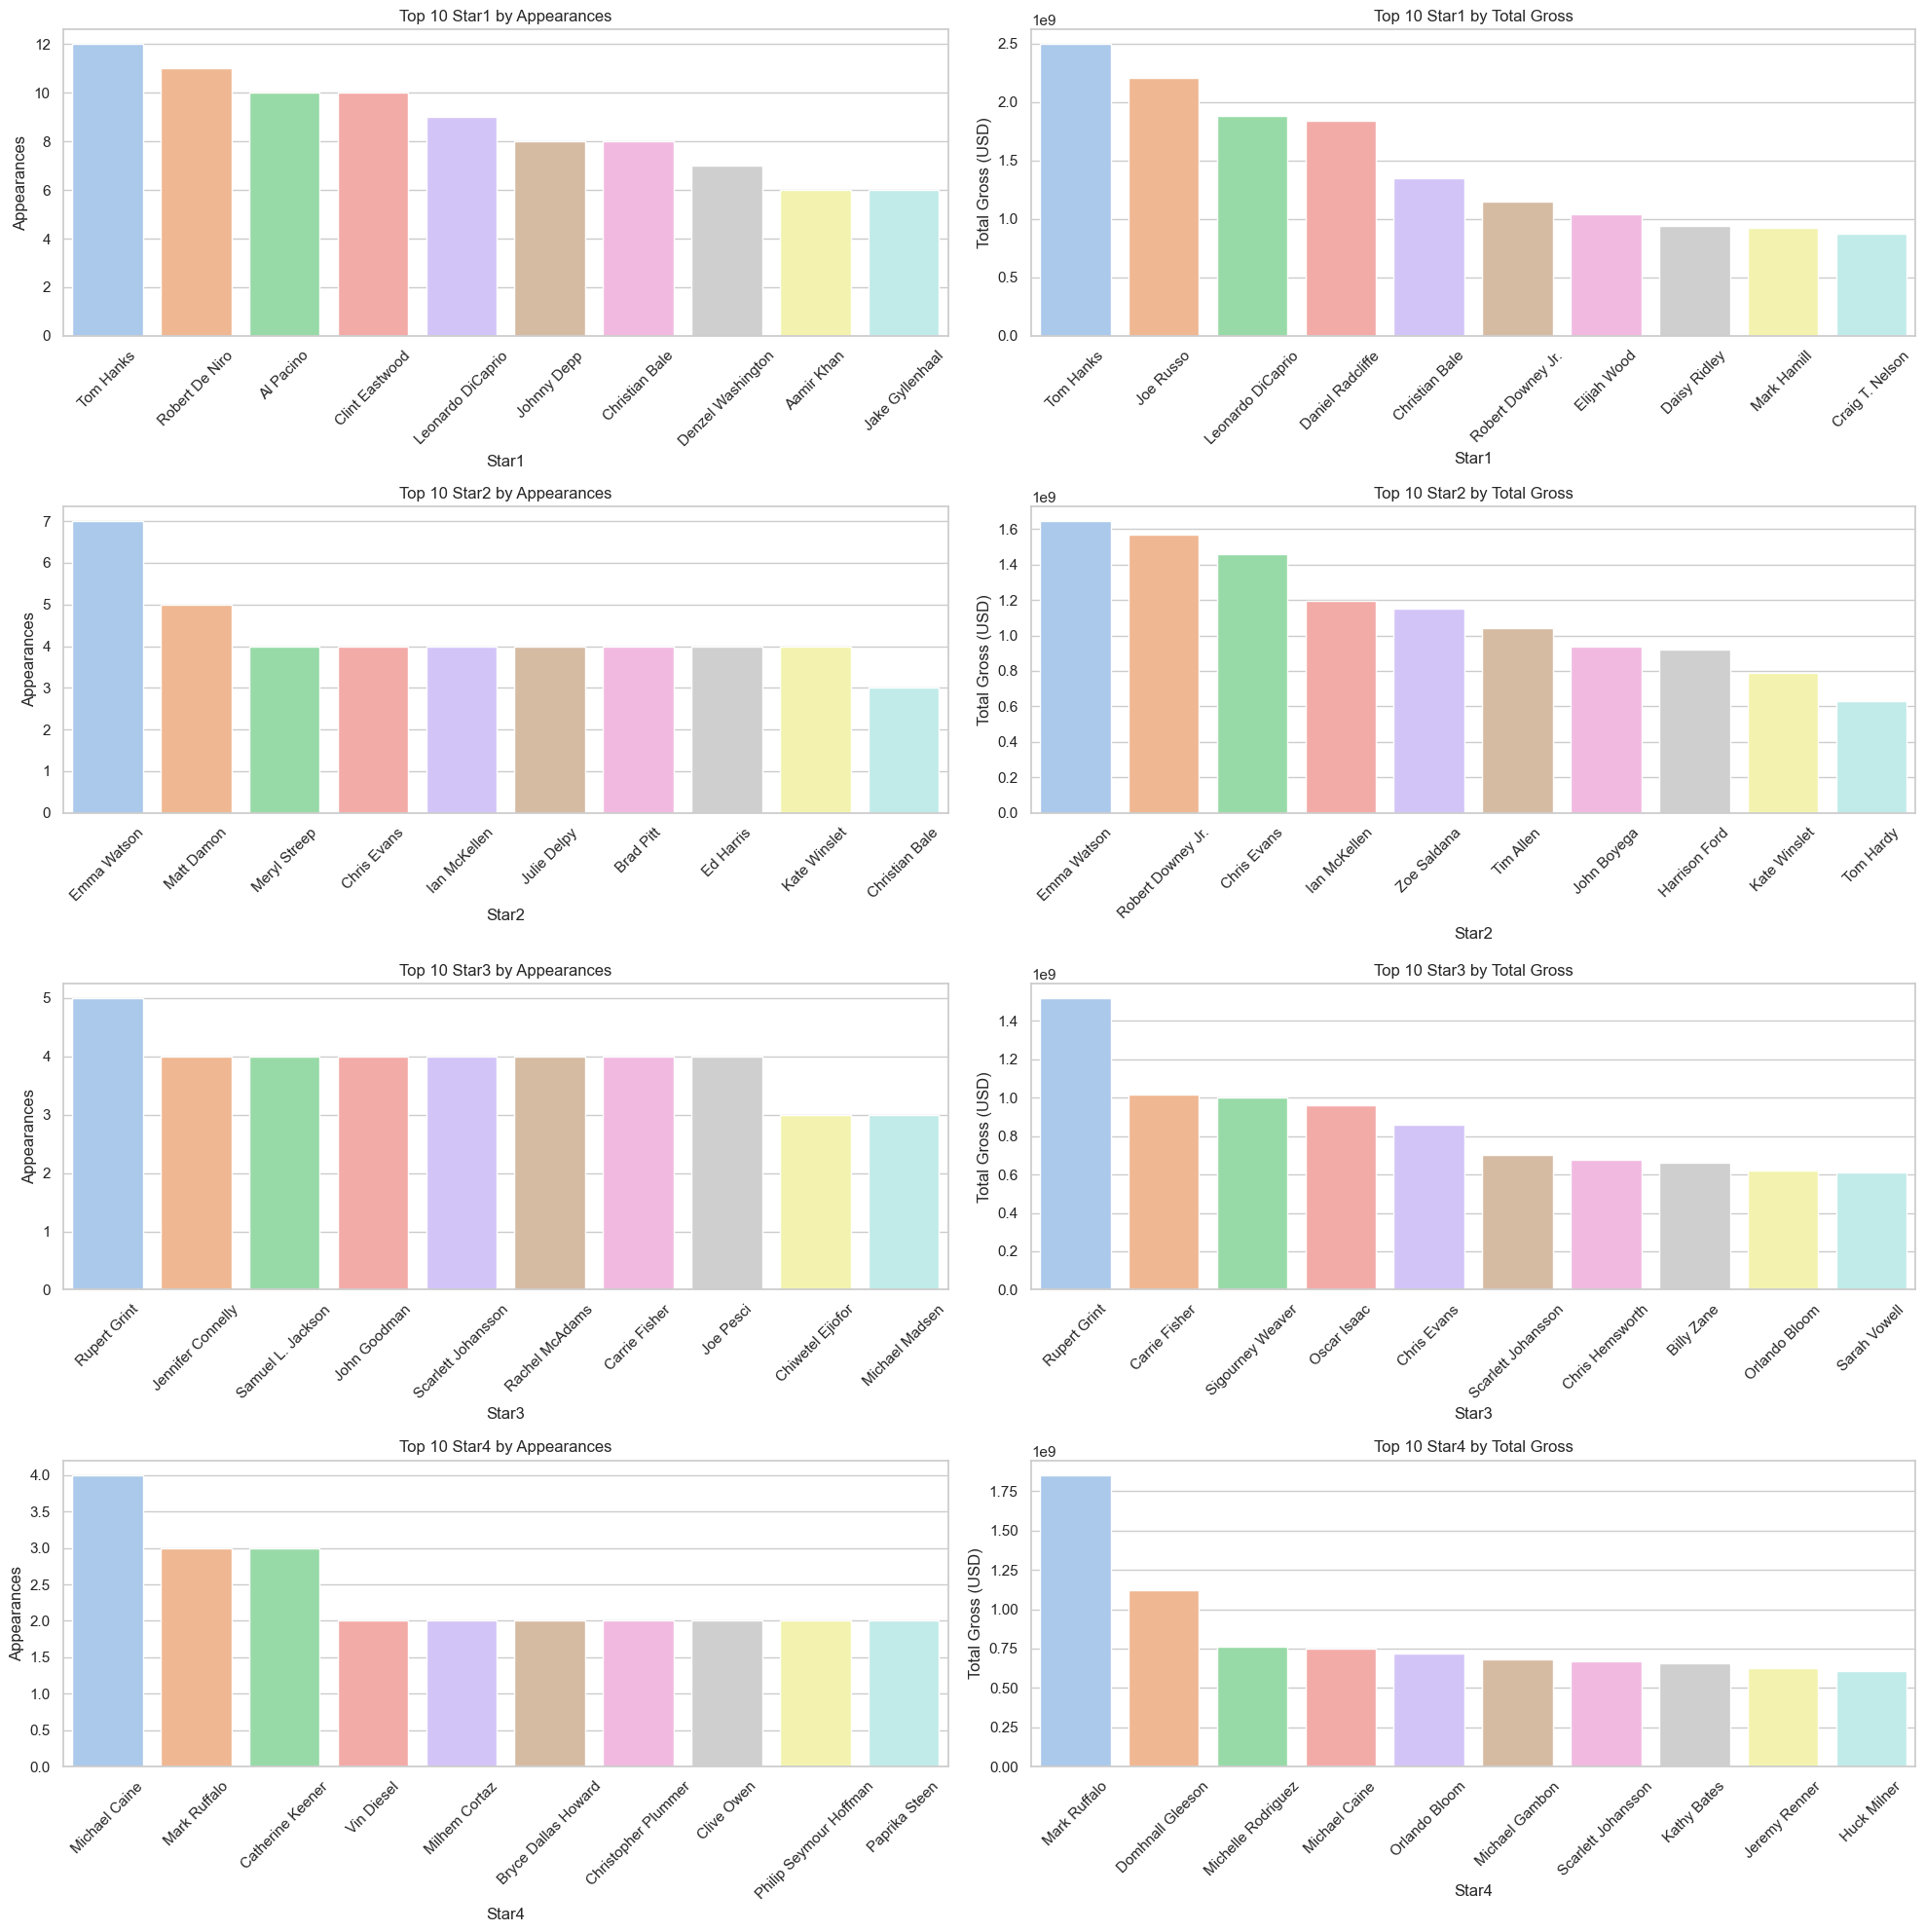

In [ ]:
# Call the function
stars_appearances_vs_gross(df_clean, top_n=10)


C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:400: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_directors_count.index, y=top_directors_count.values, palette='pastel', ax=ax)


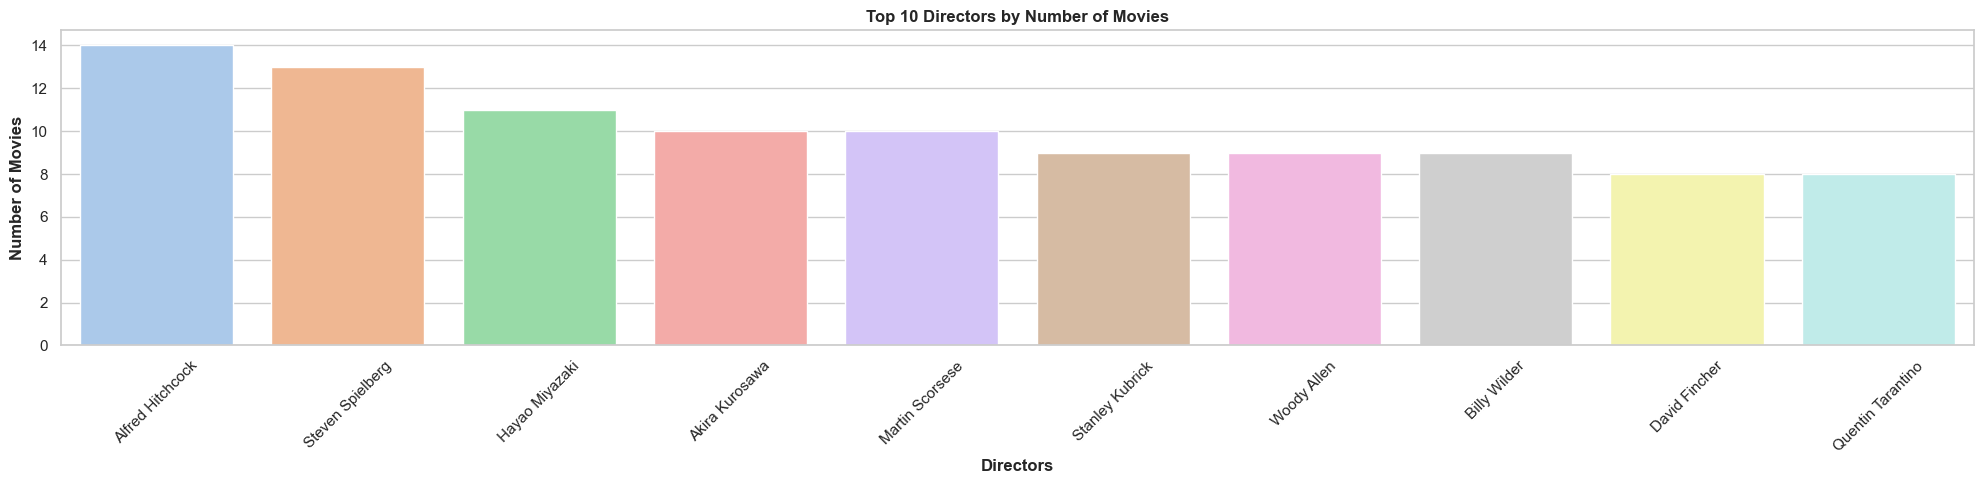

C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:411: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_imdb.index, y=avg_imdb.values, palette='pastel', ax=ax)


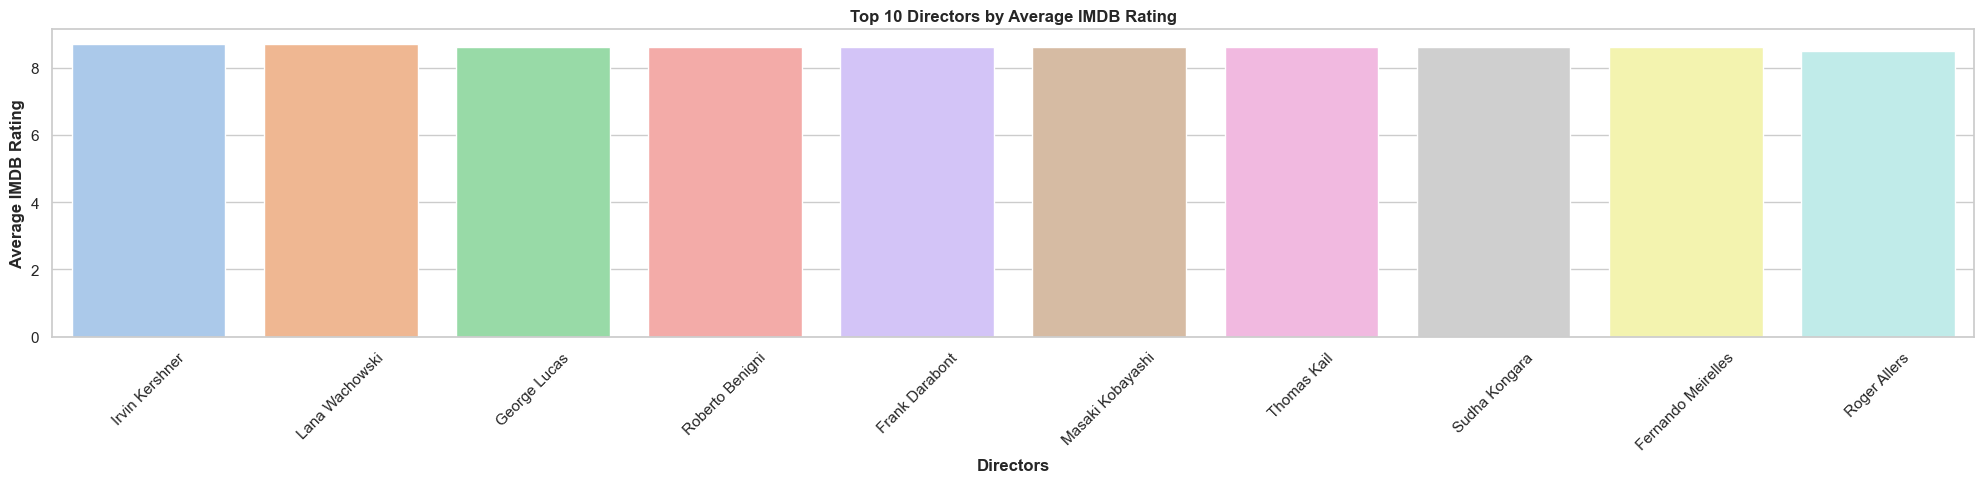

C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:422: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_meta.index, y=avg_meta.values, palette='pastel', ax=ax)


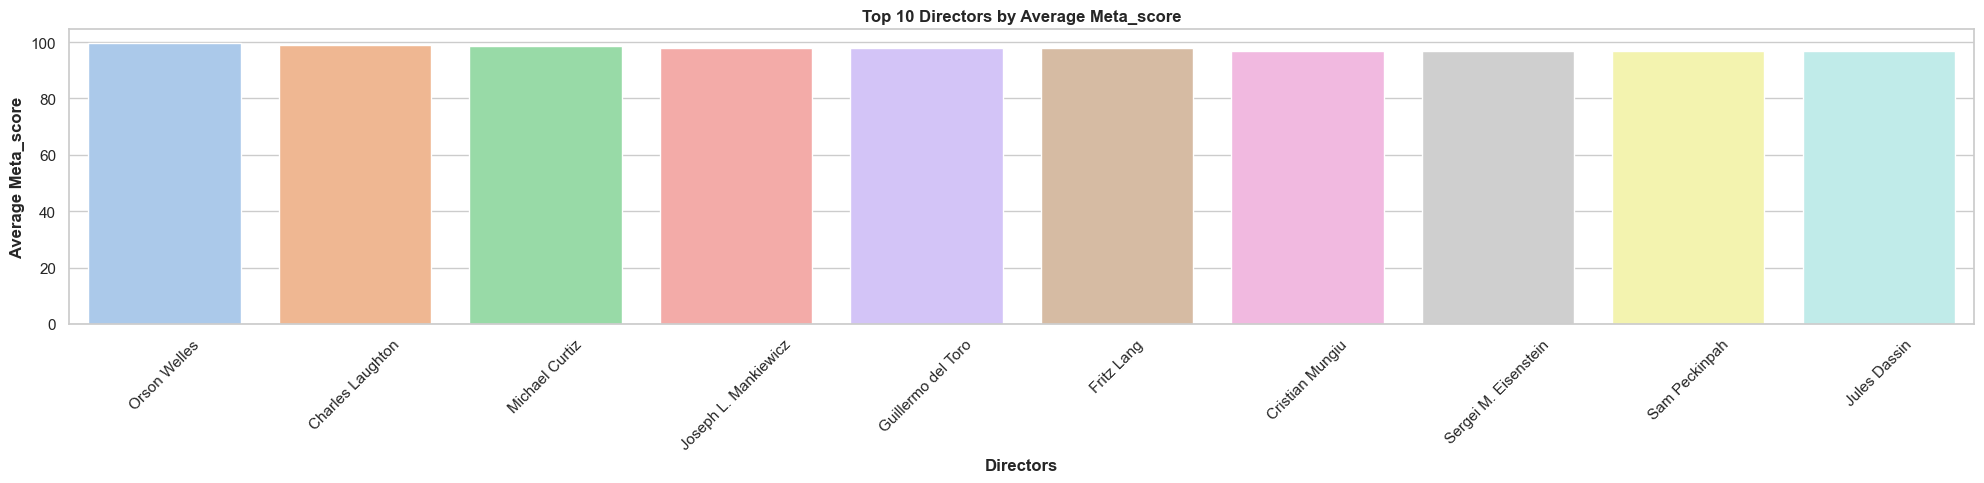

In [ ]:
directors_analysis(df_clean, top_n=10)

Top 10 movies by Gross_USD:
                                    Movie_title    Gross_USD
476  Star Wars: Episode VII - The Force Awakens  936662225.0
58                            Avengers: Endgame  858373000.0
622                                      Avatar  760507625.0
59                       Avengers: Infinity War  678815482.0
651                                     Titanic  659325379.0
356                                The Avengers  623279547.0
890                               Incredibles 2  608581744.0
1                               The Dark Knight  534858444.0
581                                   Rogue One  532177324.0
62                        The Dark Knight Rises  448139099.0


C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:465: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gross_USD', y='Movie_title', data=top_gross, palette='pastel')


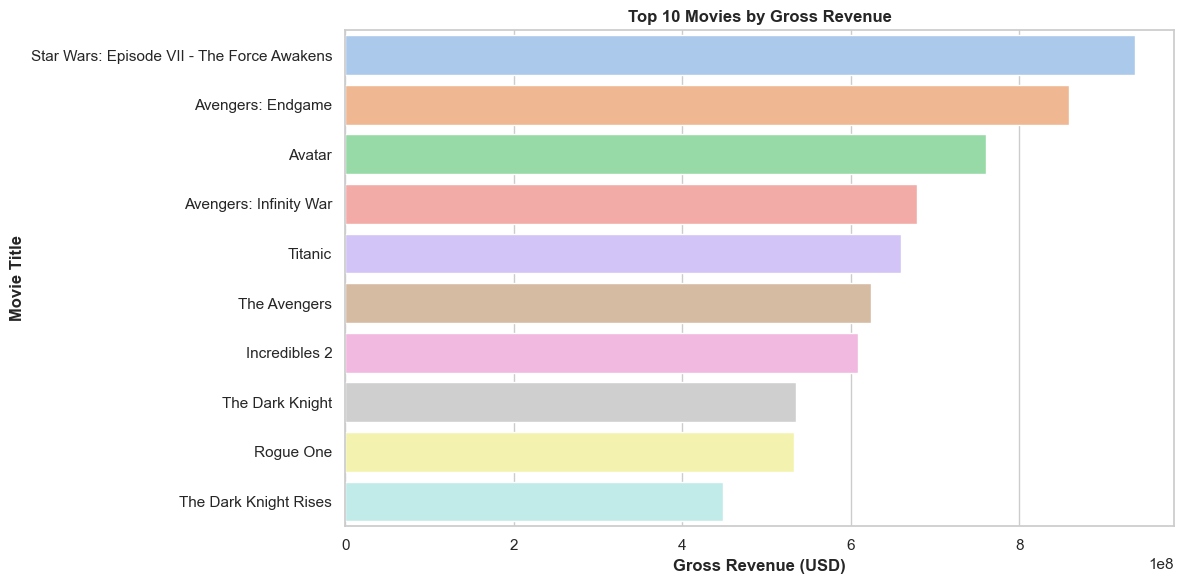


Top 10 movies by IMDB Rating:
                                         Movie_title  IMDB_Rating
0                                      The Godfather          9.2
2                             The Godfather: Part II          9.0
3                                       12 Angry Men          9.0
1                                    The Dark Knight          9.0
4      The Lord of the Rings: The Return of the King          8.9
5                                       Pulp Fiction          8.9
6                                   Schindler's List          8.9
7                                          Inception          8.8
8                                         Fight Club          8.8
9  The Lord of the Rings: The Fellowship of the Ring          8.8


C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:478: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='IMDB_Rating', y='Movie_title', data=top_imdb, palette='pastel')


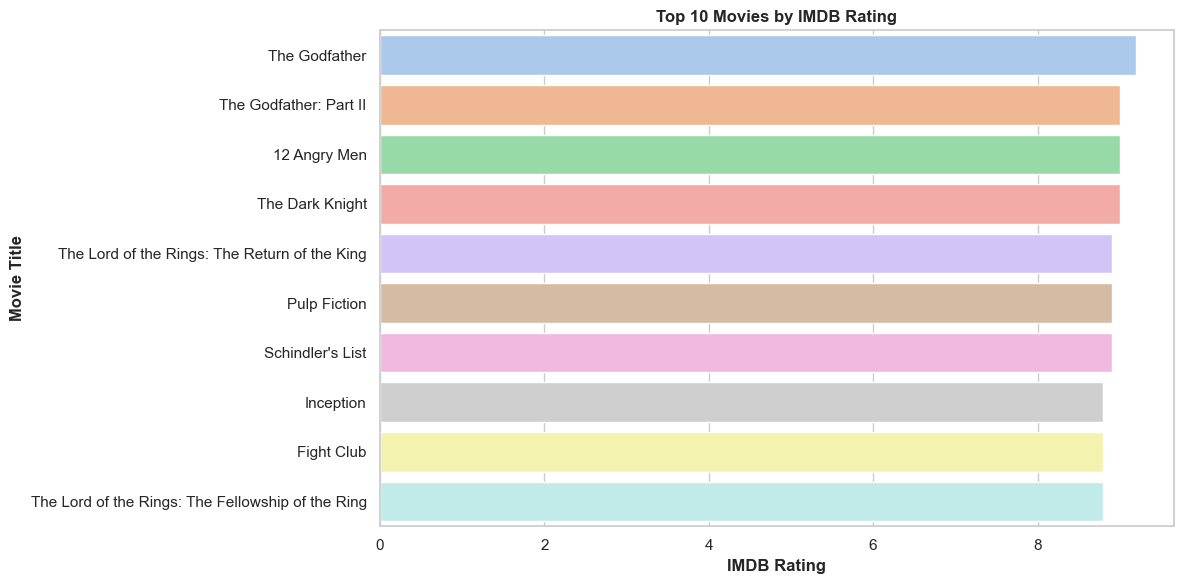


Top 10 movies by Meta_score:
                Movie_title  Meta_score
0             The Godfather       100.0
558               Notorious       100.0
118                 Vertigo       100.0
123            Citizen Kane       100.0
259   Trois couleurs: Rouge       100.0
273     Fanny och Alexander       100.0
80              Rear Window       100.0
422          Il conformista       100.0
439  Sweet Smell of Success       100.0
49               Casablanca       100.0


C:\Users\maria\OneDrive\Área de Trabalho\LH_CD_MARIAJULIAPESSOA\src\plots.py:491: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Meta_score', y='Movie_title', data=top_meta, palette='pastel')


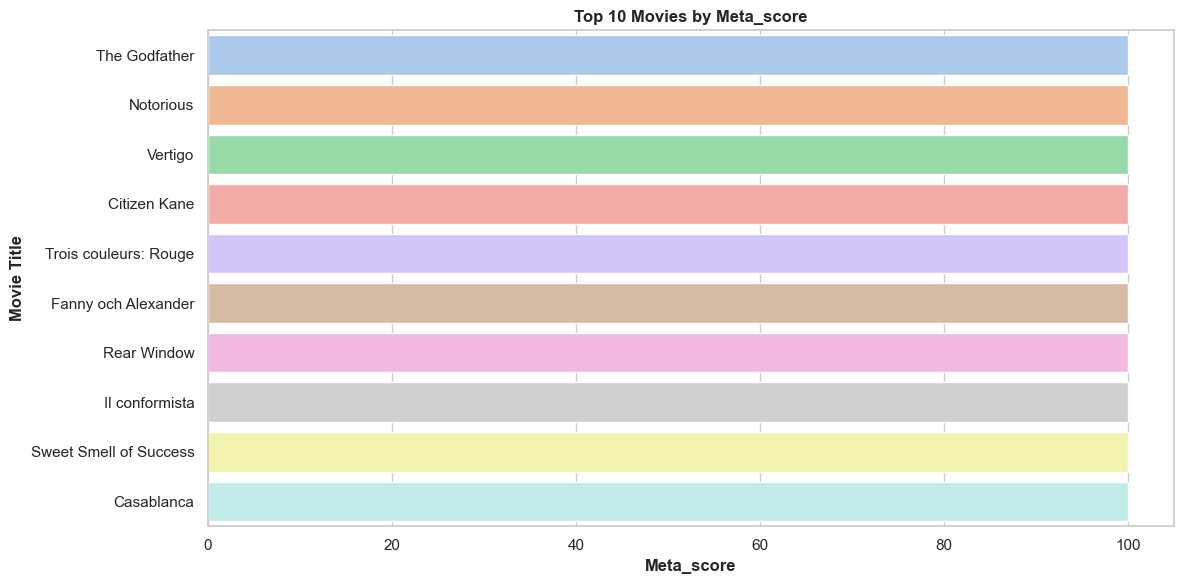


Correlation between Gross and IMDB Rating: 0.099
Correlation between Gross and Meta_score: -0.030


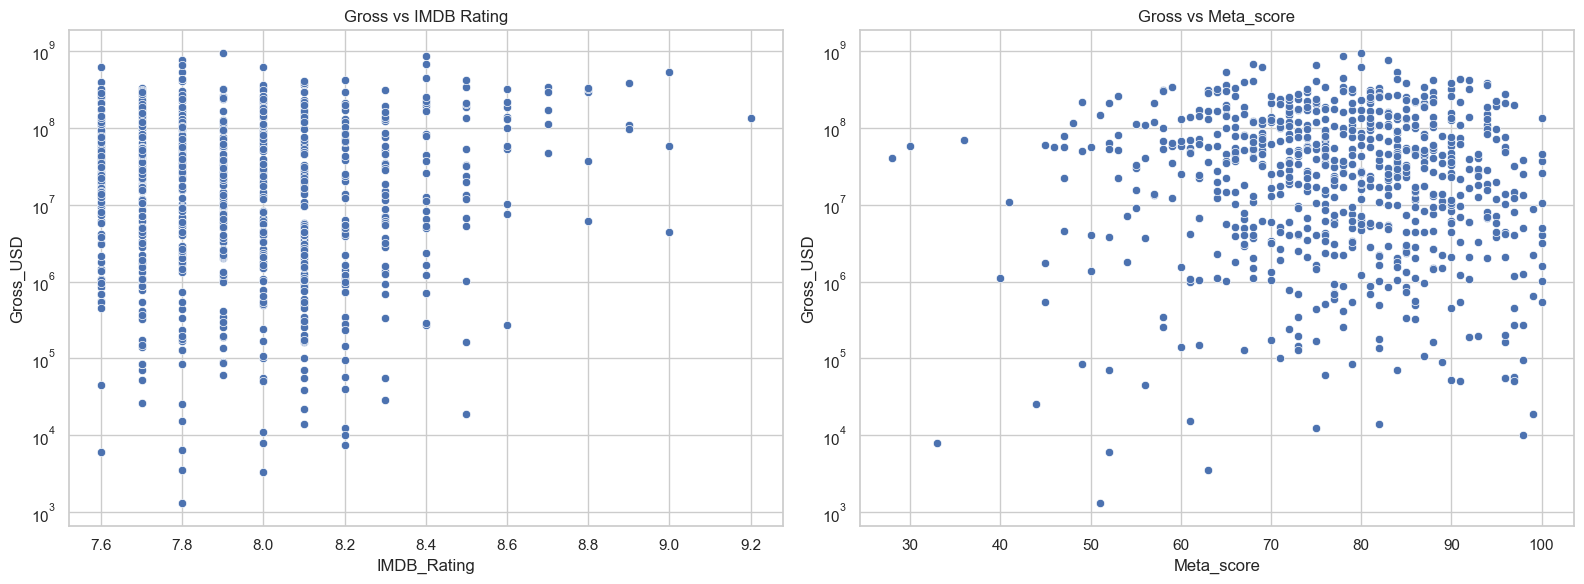

In [ ]:
top_movies_analysis(df_clean, top_n=10)

Answering questions

In [ ]:
# Ensure numeric types
df_clean['IMDB_Rating'] = pd.to_numeric(df_clean['IMDB_Rating'], errors='coerce')
df_clean['Meta_score'] = pd.to_numeric(df_clean['Meta_score'], errors='coerce')

# Drop rows with missing ratings
df_ratings = df_clean.dropna(subset=['IMDB_Rating', 'Meta_score'])

# Option 1: prioritize IMDB_Rating
top_imdb = df_ratings.sort_values(by=['IMDB_Rating', 'Meta_score'], ascending=False).iloc[0]

print("Top-rated movie recommendation:")
print(f"Title: {top_imdb['Movie_title']}")
print(f"IMDB Rating: {top_imdb['IMDB_Rating']}")
print(f"Meta Score: {top_imdb['Meta_score']}")


Top-rated movie recommendation:
Title: The Godfather
IMDB Rating: 9.2
Meta Score: 100.0


In [ ]:
import pandas as pd

# Ensure numeric types
df_clean['Gross_USD'] = pd.to_numeric(df_clean['Gross_USD'], errors='coerce')
df_clean['IMDB_Rating'] = pd.to_numeric(df_clean['IMDB_Rating'], errors='coerce')
df_clean['Meta_score'] = pd.to_numeric(df_clean['Meta_score'], errors='coerce')
df_clean['Runtime_Min'] = pd.to_numeric(df_clean['Runtime_Min'], errors='coerce')

# 1️⃣ Correlation of numeric features with Gross_USD
numeric_cols = ['IMDB_Rating', 'Meta_score', 'Runtime_Min']
corr_df = df_clean[numeric_cols + ['Gross_USD']].corr()['Gross_USD'].sort_values(ascending=False)
print("Correlation with Gross_USD (numeric factors):\n", corr_df)

# 2️⃣ Star power: total gross per actor
stars = ['Star1', 'Star2', 'Star3', 'Star4']
for star in stars:
    top_actors = df_clean.groupby(star)['Gross_USD'].sum().sort_values(ascending=False).head(10)
    print(f"\nTop 10 {star} by total gross:\n", top_actors)

Correlation with Gross_USD (numeric factors):
 Gross_USD      1.000000
Runtime_Min    0.140002
IMDB_Rating    0.099393
Meta_score    -0.030480
Name: Gross_USD, dtype: float64

Top 10 Star1 by total gross:
 Star1
Tom Hanks            2.493097e+09
Joe Russo            2.205039e+09
Leonardo DiCaprio    1.877322e+09
Daniel Radcliffe     1.835901e+09
Christian Bale       1.351591e+09
Robert Downey Jr.    1.150720e+09
Elijah Wood          1.035942e+09
Daisy Ridley         9.366622e+08
Mark Hamill          9.223406e+08
Craig T. Nelson      8.700228e+08
Name: Gross_USD, dtype: float64

Top 10 Star2 by total gross:
 Star2
Emma Watson          1.644165e+09
Robert Downey Jr.    1.570269e+09
Chris Evans          1.456490e+09
Ian McKellen         1.195021e+09
Zoe Saldana          1.150321e+09
Tim Allen            1.040839e+09
John Boyega          9.366622e+08
Harrison Ford        9.223406e+08
Kate Winslet         7.885891e+08
Tom Hardy            6.317770e+08
Name: Gross_USD, dtype: float64

Top 10

Aqui está uma resposta direta e profissional para o relatório, totalmente em inglês:

---

**Key Factors Related to High Expected Movie Revenue**

Based on the data analysis, the main factors associated with higher expected movie revenue are:

1. **Genre**: Adventure films generate the highest gross revenue, followed by Drama, Action, Comedy, and Sci-Fi. Genre significantly influences audience appeal and box office performance.

2. **Star Power**: Certain actors consistently drive high revenue. Lead actors like Tom Hanks, Leonardo DiCaprio, and Daniel Radcliffe, as well as secondary and supporting actors such as Emma Watson, Robert Downey Jr., and Mark Ruffalo, contribute substantially to total gross. High-profile actors can attract larger audiences regardless of the number of appearances.

3. **Movie Runtime**: Longer movies tend to earn slightly more, suggesting that extended runtime may correlate with larger productions, more complex storytelling, or increased audience engagement.

4. **IMDB Rating**: Better-rated movies generally earn more, although the correlation is weak. High audience ratings can positively influence revenue but are not sufficient alone to guarantee success.

5. **Combination of Factors**: Revenue is rarely determined by a single factor. The interaction between genre, star power, runtime, and audience ratings collectively influences the expected gross.

In summary, the highest-grossing films are typically adventure movies featuring popular actors, with moderate-to-high audience ratings and longer runtimes.


C:\Users\maria\AppData\Local\Temp\ipykernel_37044\1093234030.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='overview_sentiment', order=['positive','neutral','negative'], palette='pastel')


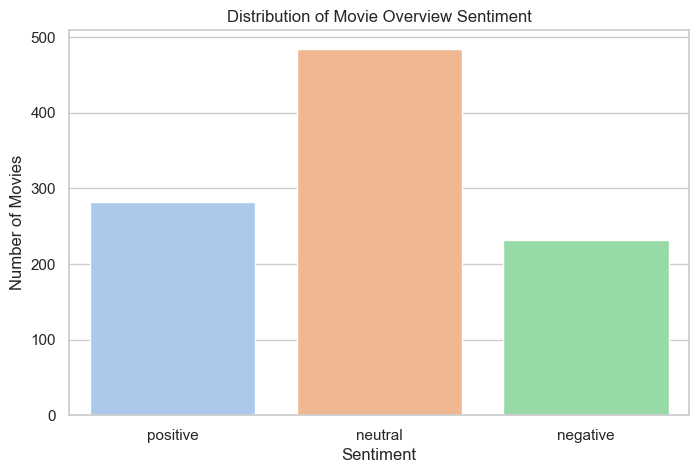

C:\Users\maria\AppData\Local\Temp\ipykernel_37044\1093234030.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='overview_sentiment', y='IMDB_Rating', order=['positive','neutral','negative'], palette='pastel')


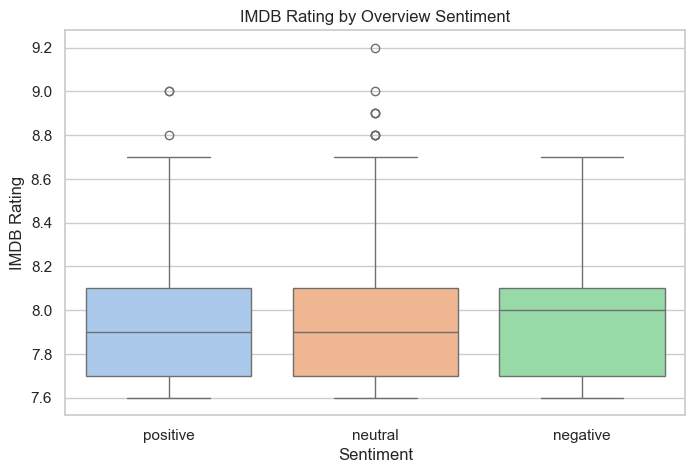

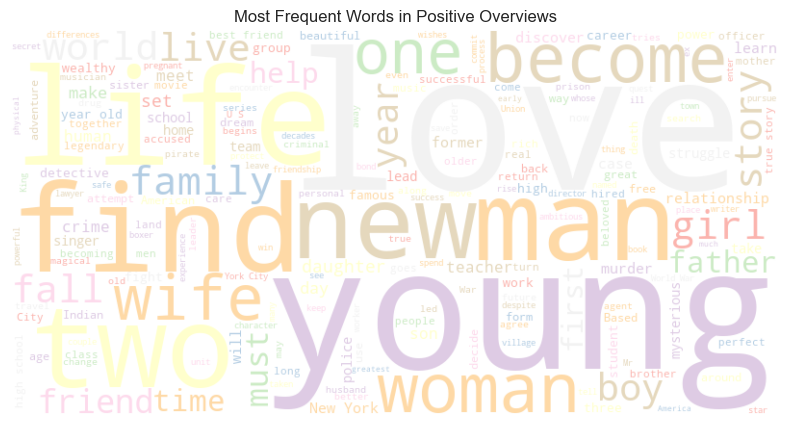

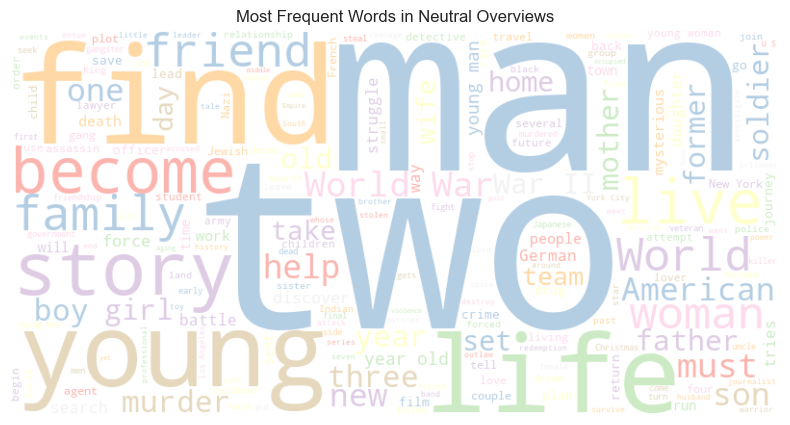

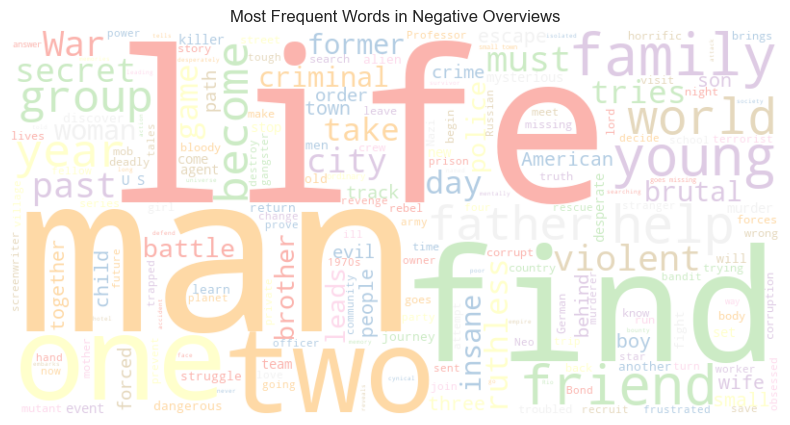

Overview Sentiment vs IMDB Rating:
                    count      mean  median
overview_sentiment                         
negative              232  7.963793     8.0
neutral               485  7.947629     7.9
positive              282  7.935461     7.9


In [ ]:
# Feature Engineering & Overview Analysis

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud

# 1️⃣ Extract features from Overview

# Word count
df['overview_word_count'] = df['Overview'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

# Sentiment analysis using TextBlob
def get_sentiment(text):
    if pd.isna(text) or not text.strip():
        return 'neutral'
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['overview_sentiment'] = df['Overview'].apply(get_sentiment)

# 2️⃣ Visualizations

# Distribution of Sentiments
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='overview_sentiment', order=['positive','neutral','negative'], palette='pastel')
plt.title('Distribution of Movie Overview Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Movies')
plt.show()

# Sentiment vs IMDB Rating
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='overview_sentiment', y='IMDB_Rating', order=['positive','neutral','negative'], palette='pastel')
plt.title('IMDB Rating by Overview Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('IMDB Rating')
plt.show()

# Wordcloud per Sentiment
for sentiment in ['positive','neutral','negative']:
    text = ' '.join(df[df['overview_sentiment']==sentiment]['Overview'].dropna())
    if text:  # skip empty sentiment groups
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Pastel1').generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Most Frequent Words in {sentiment.capitalize()} Overviews')
        plt.show()

# 3️⃣ Optional: Insights from numeric features
overview_summary = df.groupby('overview_sentiment')['IMDB_Rating'].agg(['count','mean','median'])
print("Overview Sentiment vs IMDB Rating:")
print(overview_summary)


Genre: Action
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       142
           1       0.00      0.00      0.00        27

    accuracy                           0.84       169
   macro avg       0.42      0.50      0.46       169
weighted avg       0.71      0.84      0.77       169

--------------------------------------------------
Genre: Adventure
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       135
           1       0.00      0.00      0.00        34

    accuracy                           0.80       169
   macro avg       0.40      0.50      0.44       169
weighted avg       0.64      0.80      0.71       169

--------------------------------------------------
Genre: Animation
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       154
           1       0.00      0.00      0.00        15

    accuracy                    

C:\Users\maria\AppData\Local\Temp\ipykernel_37044\1928028537.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_cols, y=accuracy_list, palette='pastel')


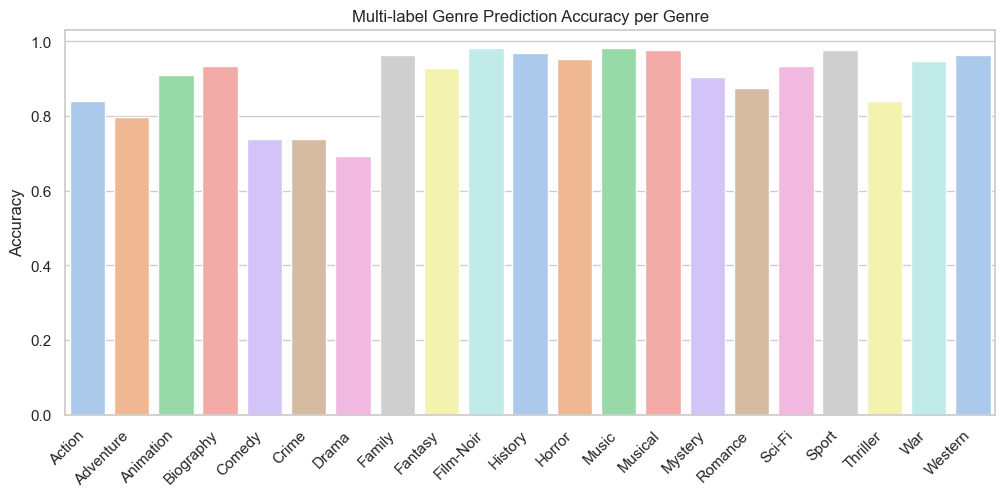

In [ ]:
# ===============================================
# Multi-label Genre Prediction from Overview
# ===============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Prepare data
# Use df_ratings and detect genre columns (multi-hot encoded, 0/1)
genre_cols = [c for c in df_ratings.columns if set(df_ratings[c].dropna().unique()).issubset({0,1}) and c not in ['SomeNonGenreCol']]

X = df_ratings['Overview'].fillna("")  # Use empty string if NaN
y = df_ratings[genre_cols].fillna(0).astype(int)  # Ensure numeric multi-hot

# 2️⃣ Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3️⃣ TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# 4️⃣ Train MultiOutputClassifier
clf = MultiOutputClassifier(MultinomialNB())
clf.fit(X_train_tfidf, y_train)

# 5️⃣ Predict
y_pred = clf.predict(X_test_tfidf)

# 6️⃣ Evaluation per genre
for idx, genre in enumerate(genre_cols):
    print(f"Genre: {genre}")
    print(classification_report(y_test.iloc[:, idx], y_pred[:, idx], zero_division=0))
    print("-"*50)

# 7️⃣ Optional: plot accuracy/f1-score per genre
accuracy_list = []
for idx, genre in enumerate(genre_cols):
    acc = (y_test.iloc[:, idx] == y_pred[:, idx]).mean()
    accuracy_list.append(acc)

plt.figure(figsize=(12,5))
sns.barplot(x=genre_cols, y=accuracy_list, palette='pastel')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Multi-label Genre Prediction Accuracy per Genre")
plt.show()
